<a href="https://colab.research.google.com/github/adithyamauryakr/BANDNN_PyTorch/blob/main/BANDNN_mirror.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit
!git clone https://github.com/adithyamauryakr/BANDNN_pytorch.git
!git clone https://github.com/isayev/ANI1_dataset.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 35.1 MB/s eta 0:00:00
Cloning into 'BANDNN_pytorch'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 114 (delta 63), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (114/114), 3.12 MiB | 5.60 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Cloning into 'ANI1_dataset'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 81 (delta 6), reused 13 (delta 4), pack-reused 63 (from 1)
Receiving objects: 100% (81/81), 2.69 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [2]:
!export PYTHONPATH="${PYTHONPATH}:/content/ANI1_dataset/readers/lib to PYTHONPATH"

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import lib.pyanitools as pya
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import h5py
PATH = '/content/drive/MyDrive/bandnn_datasets/molecules.h5'
features_list = []
with h5py.File(PATH, 'r') as h5f:
    for mol_key in h5f.keys():
        group = h5f[mol_key]
        mol_data = {key: group[key][()] for key in group}
        for k, v in mol_data.items():
            if isinstance(v, bytes):
                mol_data[k] = v.decode('utf-8')
        features_list.append(mol_data)

print(len(features_list))

100000


In [6]:
y = pd.read_csv('/content/drive/MyDrive/bandnn_datasets/energy_list.csv').values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    features_list, y, test_size=0.2, random_state=42
)

In [8]:
class CustomDataset(Dataset):

  def __init__(self, features, targets):
    self.features = features
    self.targets = torch.tensor(targets, dtype=torch.float32)

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, index):
    return self.features[index], self.targets[index]

In [9]:
def collate_Fn(batch):
    feature_batch, target_batch = zip(*batch)
    return list(feature_batch), torch.tensor(target_batch, dtype=torch.float32)


In [10]:

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32,collate_fn=collate_Fn, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_Fn, shuffle=False, pin_memory=True)



(array([  295.,   868.,  2618.,  5755.,  7832., 16837., 20639., 25447.,
        14928.,  4781.]),
 array([-471.57122759, -455.4379652 , -439.3047028 , -423.17144041,
        -407.03817801, -390.90491562, -374.77165322, -358.63839082,
        -342.50512843, -326.37186603, -310.23860364]),
 <BarContainer object of 10 artists>)

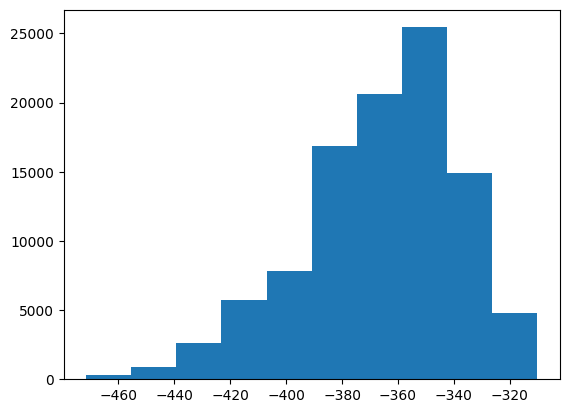

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y)

In [11]:
BONDS_DIM, ANGLES_DIM, NONBONDS_DIM, DIHEDRALS_DIM = 17, 27, 17, 38

In [12]:
torch.manual_seed(42)

class BANDNN(nn.Module):

    def __init__(self, bonds_input_dim, angles_input_dim, nonbonds_input_dim, dihedral_input_dim):
        super().__init__()
        self.bonds_model = nn.Sequential(
            nn.Linear(bonds_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.angles_model = nn.Sequential(
            nn.Linear(angles_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 350),
            nn.ReLU(),
            nn.Linear(350, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.nonbonds_model = nn.Sequential(
            nn.Linear(nonbonds_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.dihedrals_model = nn.Sequential(
            nn.Linear(dihedral_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, bonds_input, angles_input, non_bonds_input, dihedrals_input):
        bonds_energy = self.bonds_model(bonds_input).sum()
        angles_energy = self.angles_model(angles_input).sum()
        nonbonds_energy = self.nonbonds_model(non_bonds_input).sum()
        dihedrals_energy = self.dihedrals_model(dihedrals_input).sum()

        total_energy = bonds_energy + angles_energy + nonbonds_energy + dihedrals_energy
        return total_energy


In [13]:
!pip install torchinfo

In [14]:
from torchinfo import summary
model = BANDNN(BONDS_DIM, ANGLES_DIM, NONBONDS_DIM, DIHEDRALS_DIM)
model = model.to(device)
# model.summary()
summary(model)

Layer (type:depth-idx)                   Param #
BANDNN                                   --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       2,304
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       33,024
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       32,896
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       129
├─Sequential: 1-2                        --
│    └─Linear: 2-8                       3,584
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      45,150
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      44,928
│    └─ReLU: 2-13                        --
│    └─Linear: 2-14                      129
├─Sequential: 1-3                        --
│    └─Linear: 2-15                      2,304
│    └─ReLU: 2-16                        --
│    └─Linear: 2-17                      33,

In [16]:
epochs = 9
learning_rate = 0.01

# loss func
criterion = nn.MSELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# training loop

for epoch in range(epochs):
  print(f'Epoch {epoch + 1}')
  total_epoch_loss = 0
  num_samples = 0

  for batch in train_loader:

    for feature_dict, target in zip(*batch):

      bond_feat = torch.stack([torch.tensor(arr, dtype=torch.float32) for arr in feature_dict['bonds']]).to(device)
      angle_feat = torch.stack([torch.tensor(arr, dtype=torch.float32) for arr in feature_dict['angles']]).to(device)
      nonbond_feat = torch.stack([torch.tensor(arr, dtype=torch.float32) for arr in feature_dict['nonbonds']]).to(device)
      dihedral_feat = torch.stack([torch.tensor(arr, dtype=torch.float32) for arr in feature_dict['dihedrals']]).to(device)
      energy_feat = torch.tensor([target], dtype=torch.float32).to(device)

      optimizer.zero_grad()

      outputs = model(bond_feat, angle_feat, nonbond_feat, dihedral_feat)

      loss = criterion(outputs, energy_feat)
      loss.backward()

      optimizer.step()

      num_samples+=1
      total_epoch_loss += loss.item()


  avg_loss = total_epoch_loss / num_samples
  print(f'Average epoch Loss: {avg_loss:.4f}')


torch.save(model.state_dict(), 'BANDNN-weights-260425.pth')


Epoch 1


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average epoch Loss: 1026.9711
Epoch 2
Average epoch Loss: 719.5962
Epoch 3
Average epoch Loss: 686.2107
Epoch 4
Average epoch Loss: 656.3444
Epoch 5
Average epoch Loss: 647.0334
Epoch 6
Average epoch Loss: 632.6085
Epoch 7
Average epoch Loss: 622.4295
Epoch 8
Average epoch Loss: 612.3196
Epoch 9
Average epoch Loss: 601.5367


In [17]:
checkpoint = torch.load('BANDNN_pytorch/models/BANDNN-chekpoint1.pth', map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1  # start from next epoch
loss_at_checkpoint = checkpoint['loss']

model.train()

BANDNN(
  (bonds_model): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (angles_model): Sequential(
    (0): Linear(in_features=27, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=350, bias=True)
    (3): ReLU()
    (4): Linear(in_features=350, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (nonbonds_model): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (dihedra

In [18]:
a = [1, 4, 6,7]
for i in range( 10):
  if i in a:
    print(i)

1
4
6
7


In [19]:
check_point_epochs = [13, 16, 18]

for epoch in range(start_epoch, start_epoch + 11):
  print(f'Epoch {epoch + 1}')
  total_epoch_loss = 0
  num_samples = 0

  for batch in train_loader:

    for feature_dict, target in zip(*batch):

      bond_feat = torch.stack([torch.tensor(arr, dtype=torch.float32) for arr in feature_dict['bonds']]).to(device)
      angle_feat = torch.stack([torch.tensor(arr, dtype=torch.float32) for arr in feature_dict['angles']]).to(device)
      nonbond_feat = torch.stack([torch.tensor(arr, dtype=torch.float32) for arr in feature_dict['nonbonds']]).to(device)
      dihedral_feat = torch.stack([torch.tensor(arr, dtype=torch.float32) for arr in feature_dict['dihedrals']]).to(device)
      energy_feat = torch.tensor([target], dtype=torch.float32).to(device)

      optimizer.zero_grad()

      outputs = model(bond_feat, angle_feat, nonbond_feat, dihedral_feat)

      loss = criterion(outputs, energy_feat)
      loss.backward()

      optimizer.step()

      num_samples+=1
      total_epoch_loss += loss.item()


  avg_loss = total_epoch_loss / num_samples
  print(f'Average epoch Loss: {avg_loss:.4f}')
  if epoch in check_point_epochs:
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,

                }, f'BANDNN-chekpoint_epoch_{epoch}.pth')



torch.save(model.state_dict(), 'BANDNN-weights-260425-1.pth')

Epoch 10


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average epoch Loss: 596.9167
Epoch 11
Average epoch Loss: 597.3017
Epoch 12
Average epoch Loss: 593.4473
Epoch 13
Average epoch Loss: 580.4607
Epoch 14
Average epoch Loss: 584.2177
Epoch 15
Average epoch Loss: 578.9127
Epoch 16
Average epoch Loss: 573.4888
Epoch 17
Average epoch Loss: 581.4481
Epoch 18
Average epoch Loss: 573.3113
Epoch 19
Average epoch Loss: 568.6520
Epoch 20
Average epoch Loss: 568.7975


In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,

            }, 'BANDNN-chekpoint1.pth')

In [ ]:
model.eval()

BANDNN(
  (bonds_model): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (angles_model): Sequential(
    (0): Linear(in_features=27, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=350, bias=True)
    (3): ReLU()
    (4): Linear(in_features=350, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (nonbonds_model): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (dihedra

In [ ]:
from sklearn.metrics import r2_score

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()  # Set model to eval mode
    total_loss = 0
    total_samples = 0

    predictions = []
    targets_list = []

    criterion = torch.nn.MSELoss()

    with torch.no_grad():  # No gradients needed
        for batch in test_loader:
            features_list, targets = batch

            for feature, target in zip(features_list, targets):
                # Convert and move feature components to device
                bonds = torch.stack([torch.tensor(b, dtype=torch.float32) for b in feature['bonds']]).to(device)
                angles = torch.stack([torch.tensor(a, dtype=torch.float32) for a in feature['angles']]).to(device)
                nonbonds = torch.stack([torch.tensor(n, dtype=torch.float32) for n in feature['nonbonds']]).to(device)
                dihedrals = torch.stack([torch.tensor(d, dtype=torch.float32) for d in feature['dihedrals']]).to(device)

                target = torch.tensor(target, dtype=torch.float32).to(device)

                # Get model output
                output = model(bonds, angles, nonbonds, dihedrals)

                # Compute loss
                loss = criterion(output, target)
                total_loss += loss.item()
                total_samples += 1

                predictions.append(output.item())
                targets_list.append(target.item())

    avg_loss = total_loss / total_samples

    print(f"Evaluation MSE Loss: {avg_loss:.4f}")
    print(f"Evaluation R2 Score: {r2_score(targets_list, predictions):.4f}")
    return predictions, targets_list, avg_loss


In [ ]:
model.to(device)
preds, true_vals, test_loss = evaluate_model(model, test_loader, device)


<ipython-input-16-747d92950de0>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.float32).to(device)


Evaluation MSE Loss: 598.5417
Evaluation R2 Score: 0.3479


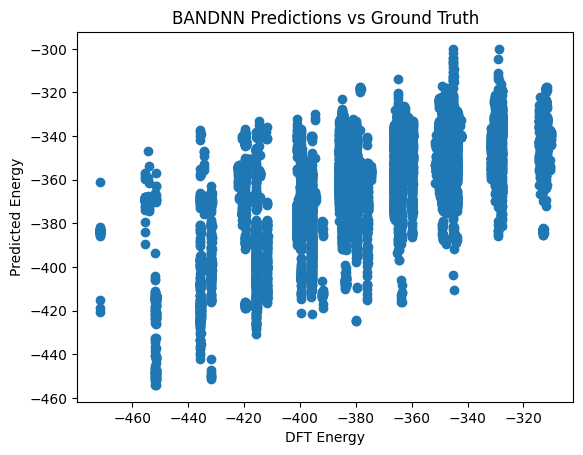

In [ ]:
# Model trained with lr = 0.01, epochs = 9

import matplotlib.pyplot as plt

plt.scatter(true_vals, preds)
plt.xlabel("DFT Energy")
plt.ylabel("Predicted Energy")
plt.title("BANDNN Predictions vs Ground Truth")

plt.show()


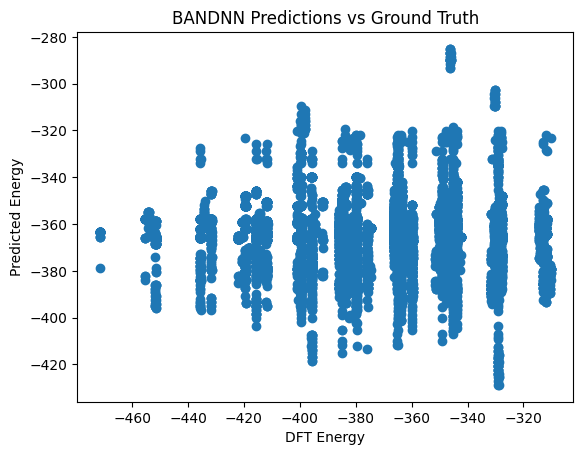

In [ ]:
# Model trained with lr = 0.1

import matplotlib.pyplot as plt

plt.scatter(true_vals, preds)
plt.xlabel("DFT Energy")
plt.ylabel("Predicted Energy")
plt.title("BANDNN Predictions vs Ground Truth")

plt.show()
